<a href="https://colab.research.google.com/github/kuan0808/Med_Conversation_NER/blob/master/med_report_ver3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ver3.3
####Chang  log:
- 使用繁轉簡，再分詞
- 使用pretrain但改用matrix load in Embedding layer(trainable=True)
- 更改generator的演算法
- 可視化Embedding vector分布
- 嘗試計算f1score

In [ ]:
import os
import sys
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Embedding, \
    GRU, Dense, TimeDistributed, Bidirectional, SpatialDropout1D
from keras.models import Model, Input
from keras.utils import plot_model, Sequence
import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

import datetime

import jieba
import jieba.posseg as pseg

from sklearn.model_selection \
    import train_test_split

%pip install opencc-python-reimplemented
from opencc import OpenCC

%pip install gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.keyedvectors import KeyedVectors

     |████████████████████████████████| 491kB 2.7MB/s 
  Created wheel for opencc-python-reimplemented: filename=opencc_python_reimplemented-0.1.6-py2.py3-none-any.whl size=486137 sha256=4df795041fe33f18ac3851db17f45b2ef515cb381487ea3761db276d6d244536
  Stored in directory: /root/.cache/pip/wheels/54/8a/0f/405db0ba3f02d9af8211422d3ae94c47b3296256f168ac1e68
Successfully built opencc-python-reimplemented


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### teat

In [ ]:
output_folder = '/content/gdrive/My Drive/Colab Notebooks'
train_file_path = os.path.join(output_folder, 'data', 'train_1_update.txt')
test_file_path = os.path.join(output_folder, 'data', 'SampleData_deid.txt')
os.path.isfile(train_file_path)
os.path.isfile(test_file_path)

True

##  資料預處理

In [ ]:
def preprocess(path, is_train = True):
    content_list = []
    label_list = []
    with open(path, 'r', encoding='utf8') as f:
        raw_data=f.read().encode('utf-8').decode('utf-8-sig')
    articles = raw_data.split('\n\n--------------------\n\n')[:-1]
    for article in articles:
        label_tmp = []
        content = article.split('\n')[0]
        content.replace(' ', '')
        content_list.append(content)
        if is_train:
            for labels in article.split('\n')[2:]:
                label = labels.split('\t')
                label_tmp.append([int(label[1]), int(label[2]), label[4]])
            label_list.append(label_tmp)
    #Traditional 2 Simple
    cc = OpenCC('t2s')
    simple_content_list = [cc.convert(s) for s in content_list]
    
    if is_train:
        return simple_content_list, label_list
    return simple_content_list

## Jieba分詞

In [ ]:
def jieba_tokenizer(content_list):
    syntax = ['，', '。', '!', '?', ':', '！', '？', '：', '......', '；', '、', '~', '～', '%', '％']
    word_pos_list = []
    tokenized_content_list = []
    for content in content_list:
        tokenized_content_list_tmp = []
        word_pos_list_tmp = []
        result = jieba.tokenize(content)
        # words = pseg.cut(content)
        # tokenized_content_list_tmp = [word for word, flag in words if (flag != 'x' & word != '......')]
        for word, start, end in result:
            if word not in syntax:
                # try:
                #     num = int(word)
                #     word = '10'
                # except:
                    tokenized_content_list_tmp.append(word)
                    word_pos_list_tmp.append([start, end])

        tokenized_content_list.append(tokenized_content_list_tmp)

        word_pos_list.append(word_pos_list_tmp)
    
    return tokenized_content_list, word_pos_list

In [ ]:
a = '我 是 大帥哥'
b = jieba.cut(a, cut_all=False)
# print(list(b))
print("Full Mode: " + "".join(b))  # 全模式


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.602 seconds.
Prefix dict has been built successfully.


Full Mode: 我 是 大帥哥


### test

In [ ]:
simple_content_list, _= preprocess(train_file_path)
print(simple_content_list)

['医师：啊回去还好吗？民众：欸，还是虚虚的，但。医师：欸，真的。民众：好险好险。坦白讲我刚回去的时候晚上还是有盗汗。医师：盗汗。民众：阿只是前天好很多。前天就算没盗，可是一觉到天明这样。医师：一觉到天明齁。我给你看电脑断层齁。民众：嘿。还有那个病毒报告不知道出来没。医师：病毒齁。民众：对对对。医师：它有帮你验了不少，还有自体免疫呢。民众：喔。医师：我相信你之前都验过。民众：对阿。医师：哇，不过你工作压力很大欸，得溃疡。民众：欸，真的阿。医师：自体免疫，还好。民众：negative。医师：negative，阿这个是？民众：疱疹。医师：疱疹病毒的抗体也是negative。民众：嗯嗯嗯。医师：啊Q热阴性，然后第一次检查综合结果也是阴性。民众：所谓Q热就是那种蚊虫叮咬的。医师：嘿，跟动物阿、跳蚤那些比较有相关。民众：了解。医师：然后恙虫病，需再采检。没关系我们到时候要追踪再一起送疾管区。民众：可以啊，可以啊。医师：恙虫病我觉得机会少。民众：对。医师：因为恙虫病要有恙虫。民众：对阿。医师：恙虫是在离岛比较多，山区。民众：喔，了解了解。医师：然后，斑疹伤寒就是跟跳蚤比较有关系，外病啦。民众：嗯，对对对。医师：比较少见的。民众：了解了解。医师：然后EBV，喔，还有CMV病毒也都OK。民众：这是什么东西啊。医师：就是，病毒会引起你肝功能异常的。EBV还有CMV，巨细胞病毒。民众：嗯。医师：这是良性的。民众：喔，这是良性的。医师：嘿，这都是良性的，自己会好。阿但是会让你发烧。民众：嗯。医师：一阵子这样子，嗯。民众：阿这也是都没有？医师：都没有的样子。我们还验了些什么，直接调出来看。民众：嗯。医师：阿不过你来的时候发炎指数比较高。发炎指数比较高，CRP。然后肝功能比较异常，85，102。民众：这个可能是没睡好。医师：也有可能。你有没有喝酒应酬？民众：喝酒，其实一阵子没有了欸。医师：一阵子没有。民众：对。你说假如是前年，那有可能，但是去年可能。医师：就没有。民众：对阿。因为老实讲，我前年都在对岸比较多。医师：喔，前年。民众：对。医师：它，Google有设厂喔？民众：欸，客户在那边。医师：客户在那边。民众：对对，阿也有设厂，也有设厂。医师：你是做，跑业务这样子。民众：对对对。医师：Google不是，那做什么，ABS？民众：ABS。ABS阿，跟那个压克力。医师：压克力这样子。所以我，我们，

In [ ]:
# a = '我是，潘、冠廷......，我是一萬個感恩1234：；:,.、惜福99%，~～12.6%。'
# words = pseg.cut(a)
# print([(word, flag) for word, flag in words])
# print([word for word, flag in words if flag != 'x' and word != '......'])

In [ ]:
# tokenized_content_list, word_pos_list = jieba_tokenizer(content_list)
# print(tokenized_content_list)

##  Pre_train Embedding layer

### Embedding layer training


---


from gensim.keyedvectors import KeyedVectors
#### Save Model
- 只有這樣存才能繼續訓練!

   `model.save(fname)`

-  這樣存佔用空間較少(C binary format)

   `model.wv.save_word2vec_format(outfile + '.model.bin', binary=True)`  

-  磁碟空間大(C text format)

   `model.wv.save_word2vec_format(outfile + '.model.txt', binary=False)`

#### Load Model
- Load 進整個模型

    `model = gensim.models.Word2Vec.load(fname)`

- Load進詞向量

    `word_vectors = KeyedVectors.load_word2vec_format('/tmp/vectors.txt', binary=False)`

    `word_vectors = KeyedVectors.load_word2vec_format('/tmp/vectors.bin', binary=True)`

#### 最省記憶體的載入方法
`model = gensim.models.Word2Vec.load('model path')`
`word_vectors = model.wv`
`del model`
`word_vectors.init_sims(replace=True)`


#### 增量訓練
`model = gensim.models.Word2Vec.load(temp_path)`

`more_sentences = [['Advanced', 'users', 'can', 'load', 'a', 'model', 'and', 'continue', 'training', 'it', 'with', 'more', 'sentences']]`

`model.build_vocab(more_sentences, update=True)`

`model.train(more_sentences, total_examples=model.corpus_count, epochs=model.iter)`

In [ ]:
cc = OpenCC('t2s')

f = open('/content/gdrive/My Drive/Colab Notebooks/Competition_med/wiki.zh.txt', 'r')
target = open('/content/gdrive/My Drive/Colab Notebooks/Competition_med/tokenized_wiki.simple_zh.txt', 'w')

line = f.readline()
line_num = 0
while line:
    line_num += 1
    line = line.replace(' ', '')
    converted_line = cc.convert(line)
    temp = jieba.cut(converted_line, cut_all=False)
    tokenized_line = ' '.join(temp)
    target.writelines(tokenized_line)
    sys.stdout.write("\r")
    sys.stdout.write(f"------Processed {line_num} aricle------")
    line = f.readline()

sys.stdout.write(f'Finished t2s & tokenize {line_num} articles')

f.close()
target.close()

串流輸出內容已截斷至最後 5000 行。
------Processing 368842 aricle------
------Processing 368843 aricle------
------Processing 368844 aricle------
------Processing 368845 aricle------
------Processing 368846 aricle------
------Processing 368847 aricle------
------Processing 368848 aricle------
------Processing 368849 aricle------
------Processing 368850 aricle------
------Processing 368851 aricle------
------Processing 368852 aricle------
------Processing 368853 aricle------
------Processing 368854 aricle------
------Processing 368855 aricle------
------Processing 368856 aricle------
------Processing 368857 aricle------
------Processing 368858 aricle------
------Processing 368859 aricle------
------Processing 368860 aricle------
------Processing 368861 aricle------
------Processing 368862 aricle------
------Processing 368863 aricle------
------Processing 368864 aricle------
------Processing 368865 aricle------
------Processing 368866 aricle------
------Processing 368867 aricle------
------Processing 

#### test

In [ ]:
# os.stat(os.path.join(output_folder, 'Competition_med', 'tokenized_wiki.simple_zh.txt')).st_size

1465389746

In [ ]:
import multiprocessing
input = os.path.join(output_folder, 'Competition_med', 'tokenized_wiki.simple_zh.txt')
model = Word2Vec(LineSentence(input), size=512, window=5, min_count=1, workers=multiprocessing.cpu_count())

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
model.save(os.path.join(output_folder, 'Competition_med', 'wiki_simple_512.model'))
model.wv.save_word2vec_format(os.path.join(output_folder, 'Competition_med', 'wiki_simple_512.model.txt') , binary=False)

In [ ]:
##                  ##
##借用別人的pretrain##
##                  ##
dim = 0
word_vecs= {}
# open pretrained word vector file
with open('/content/gdrive/My Drive/Colab Notebooks/Competition_med/cna.cbow.cwe_p.tar_g.512d.0.txt') as f:
    for line in f:
        tokens = line.strip().split()

        # there 2 integers in the first line: vocabulary_size, word_vector_dim
        if len(tokens) == 2:
            dim = int(tokens[1])
            continue
    
        word = tokens[0] 
        vec = np.array([ float(t) for t in tokens[1:] ])
        word_vecs[word] = vec

## 轉換詞向量

In [ ]:
def word_to_vector(tokenized_content_list, embedding_dict):
    embedded_list = []

    unk_vector = np.random.rand(*(list(embedding_dict.values())[0].shape))
    for idx in range(len(tokenized_content_list)):
        embedded_list_tmp = []
        for word in tokenized_content_list[idx]:
            if word in embedding_dict.keys():
                embedded_word = embedding_dict[word]
            else:
                embedded_word = unk_vector
                
#             value = embedding_dict.get(word)
#             print(value)
#             if value:
#                 embedded_word = value
#             else:
#                 embedded_word = unk_vector
            embedded_list_tmp.append(embedded_word)
        embedded_list.append(embedded_list_tmp)
    embedded_list = list(map(lambda x: np.array(x, dtype=np.float32), embedded_list))
    return embedded_list

#### test

In [ ]:
# for label in label_list[2]:
#     print(label)

## Dataset萃取

In [ ]:
label_to_index = {}


def get_label_dic(y):
    merged_y = []
    for i in range(len(y)):
        merged_y += y[i]
    labels = list(set(merged_y))

    global label_to_index 
    label_to_index  = {l : i for i, l in enumerate(labels)}

    
def train_dataset(path, word_vecs, validation_ratio, random_state=42, valid=True):
    y_train = []
    content_list, label_list = preprocess(path)
    tokenized_content_list, word_pos_list = jieba_tokenizer(content_list)
    x_train = word_to_vector(tokenized_content_list, word_vecs) #未確定
    
    for i in range(len(tokenized_content_list)):
        y_train_tmp = []
        for j in range(len(tokenized_content_list[i])):
            time_stamp = word_pos_list[i][j]
            count = 0
            for label in label_list[i]:
                if time_stamp[0] >= label[0] and time_stamp[1] <= label[1]:
                    y_train_tmp.append(label[2])
                    count += 1
                    break
            if count == 0:
                y_train_tmp.append('O')
        y_train.append(y_train_tmp)
    get_label_dic(y_train)
    y_train = [[label_to_index[l] for l in s] for s in y_train]
    categor_method = lambda x: keras.utils.to_categorical(x, num_classes=len(label_to_index))
    y_train = [categor_method(y).astype(np.float32) for y in y_train]    
    if valid:
        x_train, x_val, y_train, y_val = train_test_split(x_train, \
                    y_train,test_size=validation_ratio, random_state=random_state)
        return x_train, x_val, y_train, y_val
    
    return x_train, y_train



#### test

In [ ]:
def test_dataset(path, word_vecs):
    content_list, label_list = preprocess(path)
    tokenized_content_list, word_pos_list = jieba_tokenizer(content_list)
    x_test = word_to_vector(tokenized_content_list, word_vecs)

    return x_test, word_pos_list, content_list

#### test

In [ ]:
x_train, x_val, y_train, y_val = train_dataset(train_file_path, word_vecs, 0.1)
x_test, word_pos_list, content_list = test_dataset(test_file_path, word_vecs)
index_to_label = {v: k for k, v in label_to_index.items()}
num_labels = len(label_to_index)
print(num_labels)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.878 seconds.
Prefix dict has been built successfully.


13


In [ ]:
print(y_train[10])
print(x_train[1].shape)
for i in range(len(x_train)):
    print(len(x_train[i]) == len(y_train[i]))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(2720, 512)
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


# Model建立

## Bidirectional GRU

In [ ]:
input_word = Input(shape = (None, 512))
model = SpatialDropout1D(0.1)(input_word)
model = Bidirectional(GRU(units = 128,return_sequences=True,recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_labels, activation ='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 512)]       0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 512)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         493056    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 13)          3341      
Total params: 496,397
Trainable params: 496,397
Non-trainable params: 0
_________________________________________________________________


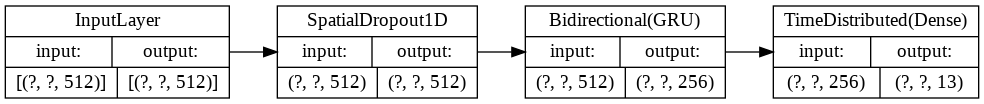

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

plot_model(
    model, 
    to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False, 
    rankdir='LR')

## Load in trained Model

In [ ]:
model_trained = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Competition_med/BiGRU_ver3-2.model')

## Data Generator

In [ ]:
def train_generator(x, y):
    while True:
        index = np.random.randint(len(x))
        Xb = np.expand_dims(x[index], axis=0)
        yb = np.expand_dims(y[index], axis=0)
        for i in range(len(x)):
            if (0 <= len(x[i]) - len(x[index]) <= 200) & (i != index):
                x_tmp = np.expand_dims(x[i][:len(x[index])], axis=0)
                y_tmp = np.expand_dims(y[i][:len(y[index])], axis=0)
                Xb = np.append(x_tmp, Xb, 0)
                yb = np.append(y_tmp, yb, 0)
        yield (Xb, yb)

In [ ]:
history = model.fit(train_generator(x_train, y_train), steps_per_epoch=50, epochs=10, verbose=1)

Epoch 1/10
50/50 [==============================] - 509s 10s/step - loss: 0.1665 - accuracy: 0.9703
Epoch 2/10
50/50 [==============================] - 447s 9s/step - loss: 0.0612 - accuracy: 0.9835
Epoch 3/10
50/50 [==============================] - 491s 10s/step - loss: 0.0485 - accuracy: 0.9865
Epoch 4/10
50/50 [==============================] - 495s 10s/step - loss: 0.0425 - accuracy: 0.9879
Epoch 5/10
50/50 [==============================] - 461s 9s/step - loss: 0.0372 - accuracy: 0.9887
Epoch 6/10
50/50 [==============================] - 491s 10s/step - loss: 0.0319 - accuracy: 0.9904
Epoch 7/10
50/50 [==============================] - 475s 10s/step - loss: 0.0275 - accuracy: 0.9914
Epoch 8/10
50/50 [==============================] - 419s 8s/step - loss: 0.0244 - accuracy: 0.9926
Epoch 9/10
50/50 [==============================] - 449s 9s/step - loss: 0.0200 - accuracy: 0.9938
Epoch 10/10
50/50 [==============================] - 387s 8s/step - loss: 0.0160 - accuracy: 0.9952


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Accuracy Curves')

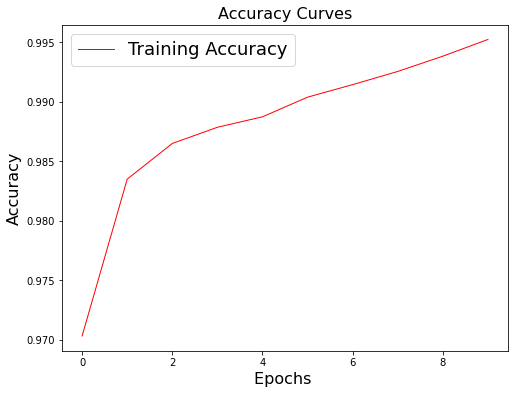

In [ ]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Text(0.5, 1.0, 'Loss Curves')

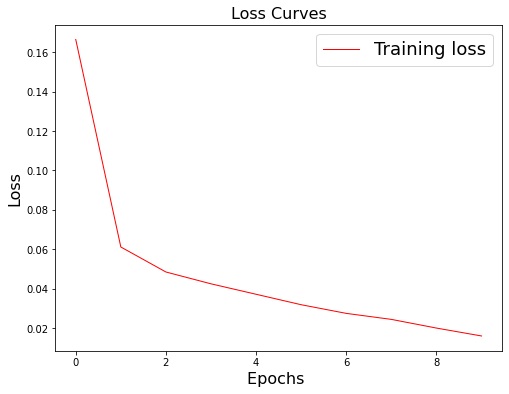

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Competition_med/BiGRU_ver3-2.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Competition_med/BiGRU_ver3-2.model/assets


In [ ]:
def check_merge(label_list):
    merged_label_list = []
    index = 0
    flag = 0
    def bool(idx, flg):
        try:
            f = (label_list[idx+flg][2] == label_list[idx+flg+1][2]) & \
                    (label_list[idx+flg][1]+1 >= label_list[idx+flg+1][0])
            return f
        except:
            return False
    while index <= len(label_list)-1:
        if bool(index, flag):
            flag += 1
        else:
            [start, end] = [label_list[index][0], label_list[index+flag][1]]
            merged_label_list.append([start, end, label_list[index][2]])
            index = index + flag + 1
            flag = 0
    return merged_label_list

category_list = []
output = 'article_id\tstart\tend\tentity_word\tentitytype\n'
for article_id in range(len(x_test)):
    y_pred = model.predict(x_test[article_id].reshape(1, *x_test[article_id].shape))

    category_list_tmp = []
    for y in np.squeeze(y_pred):
        category = np.argmax(y)
        category = index_to_label[category]
        category_list_tmp.append(category)
    label_info = []
    for i in range(len(category_list_tmp)):
        label = category_list_tmp[i]
        if label != 'O':
            stamp = word_pos_list[article_id][i]
            label_info.append([stamp[0], stamp[1], label])
    label_info = check_merge(label_info)
    for i in range(len(label_info)):
        output = output + f'{article_id}\t{label_info[i][0]}\t{label_info[i][1]}\t{content_list[article_id][label_info[i][0]:label_info[i][1]]}\t{label_info[i][2]}\n'
    category_list.append(label_info) 

In [ ]:
with open('output.txt', 'w') as fw:
    fw.write(output)
df = pd.read_table('output.txt')
pd.set_option('display.max_rows', 10000)
df

,article_id,start,end,entity_word,entitytype
0,0,1264,1269,10.78,med_exam
1,0,1376,1378,醫院,location
2,0,1863,1865,十天,time
3,0,2604,2609,3月18號,time
4,0,2613,2616,下禮拜,time
5,0,2622,2625,下禮拜,time
6,0,2630,2635,3月24日,time
7,0,2650,2654,3月24,time
8,0,2667,2670,禮拜四,time
9,0,2692,2694,3月,time


In [ ]:
df.to_csv('output.csv')